# Allstate Corporation

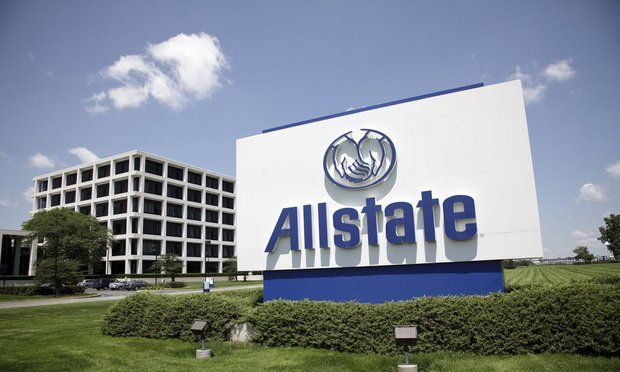

In [126]:
# hide_code
from IPython.display import Image


Image(filename="references/images/allstate.jpg",
      format='png',
      url=None,
      width=800,
      height=None,
      unconfined=True,
      metadata=None)

## Imports

In [127]:
# data analysis and data wrangling
import numpy as np
import pandas as pd

# plotting
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

# PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# Preprocessing
from sklearn.preprocessing import LabelEncoder

# machine learning
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import xgboost as xgb

# metrics
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold

# Other
from IPython.display import Image
import configparser
import subprocess
import warnings
import pprint
import time
import os

## Prepare Principal Directory

In [128]:
def exit_current_directory(end_directory: str='notebooks'):
    # PATH current
    curr_dir = os.path.dirname (os.path.realpath ("__file__")) 
    
    if curr_dir.endswith(end_directory):
        os.chdir('..')
        return curr_dir
    
    return f'Current working directory: {curr_dir}'

In [129]:
exit_current_directory(end_directory='notebooks')

'Current working directory: /home/campos/projetos/challenges/kaggle/allstate-claims-severity'

### Prepare Environment

In [130]:
# from <package>.<module> import <class>
from src.environment.prepare_env import *


main()

Requirements this project:


--------------------------------------------------
Configuration Environment:

OS:
Linux
Distributor ID:	Ubuntu
Description:	Ubuntu 19.04
Release:	19.04
Codename:	disco

Python Version:
Python 3.7.3

Pip Version:
pip 19.1.1 from /home/campos/projetos/venv_global/lib/python3.7/site-packages/pip (python 3.7)

Jupyter Version:
jupyter core     : 4.5.0
jupyter-notebook : 5.7.8
qtconsole        : 4.5.1
ipython          : 7.5.0
ipykernel        : 5.1.1
jupyter client   : 5.2.4
jupyter lab      : not installed
nbconvert        : 5.5.0
ipywidgets       : 7.4.2
nbformat         : 4.4.0
traitlets        : 4.3.2

Disk Usage Data:
112M	data/

Disk Usage All:
255M	.

--------------------------------------------------
Structure This Project:

.
├── data
│   ├── raw
│   │   ├── sample_submission.csv
│   │   ├── test.csv
│   │   └── train.csv
│   └── submissions-kaggle
├── LICENSE
├── notebooks
│   └── allstate_corporation-casptone_nanodegreed.ipynb
├── README.md
├── refer

## Format cell

In [131]:
# Guarantees visualization inside the jupyter
%matplotlib inline

# formata os dados de todas as tabelas (ponto flutuante com 2 casas)
pd.options.display.float_format = '{:.2f}'.format

# parametros de config
rc={'savefig.dpi': 75, 
    'figure.autolayout': False, 
    'figure.figsize': [15, 8], 
    'axes.labelsize': 18,
    'axes.titlesize': 18, 
    'font.size': 18, 
    'lines.linewidth': 2.0, 
    'lines.markersize': 8, 
    'legend.fontsize': 16,
    'xtick.labelsize': 16, 
    'ytick.labelsize': 16}

# Print all rows and columns. Dont hide any
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Definition color and map de colors
default_color = '#56B4E9'
colormap = plt.cm.cool

# Single colour palettes for good and bad outcomes
good_palette = ['#44cc44']
bad_palette = ['#cc4444']

# Colour palette for gender - traditional light pink (female), light blue (male)
gender_palette = ['#B0C4DE','#FFB6C1']
# Colour palette for ticket class - gold (first), silver (second), bronze (third)
class_palette = ['#FFD700','#C0C0C0','#CD7F32']

# Supress unnecessary warnings so that presentation looks clean
warnings.filterwarnings('ignore')

# graph style
sns.set(style='dark',rc=rc)

# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load dataset

In [132]:
%%time

# load data in dataset
df_train = pd.read_csv("data/raw/train.csv", 
                       encoding='utf-8')
df_test = pd.read_csv("data/raw/test.csv", 
                      encoding='utf-8')

CPU times: user 4.14 s, sys: 132 ms, total: 4.27 s
Wall time: 4.27 s


### Merge Data Sets

Merged the training and test sets temporarily.

In [133]:
# Merge datasets
frames = [df_train, df_test]
data = pd.concat(frames)

print("The merge datasets train and test:\n{} rows\n{} columns".format(data.shape[0],
                                                                      data.shape[1]))

The merge datasets train and test:
313864 rows
132 columns


### Global Variables

In [134]:
# Lists that will be manipulated in the data processing
list_columns = []
list_categorical_col = []
list_numerical_col = []

In [135]:
def get_col(df: 'dataframe', type_descr: 'numpy') -> list:
    """
    Function get list columns 
    
    Args:
    type_descr
        np.number, np.object -> return list with all columns
        np.number            -> return list numerical columns 
        np.object            -> return list object columns
    """
    try:
        col = (df.describe(include=type_descr).columns)  # pandas.core.indexes.base.Index  
    except ValueError:
        print(f'Dataframe not contains {type_descr} columns !', end='\n')    
    else:
        return col.tolist() 

In [136]:
list_numerical_col = get_col(df=data,
                             type_descr=np.number)
list_categorical_col = get_col(df=data,
                               type_descr=np.object)
list_columns = get_col(df=data,
                       type_descr=[np.object, np.number])

## Data analysis 

#### Datasets
The dataset contains 2 .csv files with information needed to make a forecast. They are::<br/>
1. Variables in train.csv and test.csv: 
 - **id:** the id of a couple of questions from the training set
 - **cat1 to cat116:** category variables (the range of values is not provided, nor the column names).
 - **cont1 to cont14:** continuous variables (the range of values is not provided nor the names of the columns).
 - **loss:** the amount that the company has to pay for a particular claim. This is the target variable.
 
 
 NOTE: In test.csv, the loss is not present, since we will predict this.

In [137]:
# Size and types of the dataframe
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 313864 entries, 0 to 125545
Columns: 132 entries, cat1 to loss
dtypes: float64(15), int64(1), object(116)
memory usage: 318.5+ MB


In [138]:
print("Dataframe:\n{} rows\n{} columns"
      .format(data.shape[0],
              data.shape[1]))

Dataframe:
313864 rows
132 columns


### Data Type
Within _data_ there are 3 types of data: <br/>
- float64(15) = continuos_feature + loss
- int64(1) = id
- object(116) = categorical_feature

In [139]:
data.head()

cat1 cat10 cat100 cat101 cat102 cat103 cat104 cat105 cat106 cat107 cat108  \
0    A     A      B      G      A      A      I      E      G      J      G   
1    A     B      L      F      A      A      E      E      I      K      K   
2    A     B      L      O      A      B      E      F      H      F      A   
3    B     A      I      D      A      A      E      E      I      K      K   
4    A     B      F      J      A      A      D      E      K      G      B   

  cat109 cat11 cat110 cat111 cat112 cat113 cat114 cat115 cat116 cat12 cat13  \
0     BU     B     BC      C     AS      S      A      O     LB     A     A   
1     BI     A     CQ      A     AV     BM      A      O     DP     A     A   
2     AB     B     DK      A      C     AF      A      I     GK     B     B   
3     BI     A     CS      C      N     AE      A      O     DJ     A     A   
4      H     A      C      C      Y     BM      A      K     CK     B     A   

  cat14 cat15 cat16 cat17 cat18 cat19 cat2 cat20 cat21 cat22 cat23 cat24  \
0     A     A     A     A     A     A    B     A     A     A     B     A   
1     A     A     A     A     A     A    B     A     A     A     A     A   
2     A     A     A     A     A     A    B     A     A     A     A     A   
3     A     A     A     A     A     A    B     A     A     A     B     A   
4     A     A     A     A     A     A    B     A     A     A     B     A   

  cat25 cat26 cat27 cat28 cat29 cat3 cat30 cat31 cat32 cat33 cat34 cat35  \
0     A     A     A     A     A    A     A     A     A     A     A     A   
1     A     A     A     A     A    A     A     A     A     A     A     A   
2     A     A     A     A     A    A     A     A     A     A     A     A   
3     A     A     A     A     A    A     A     A     A     A     A     A   
4     A     A     A     A     A    A     A     A     A     A     A     A   

  cat36 cat37 cat38 cat39 cat4 cat40 cat41 cat42 cat43 cat44 cat45 cat46  \
0     A     A     A     A    B     A     A     A     A     A     A     A   
1     A     A     A     A    A     A     A     A     A     A     A     A   
2     B     A     A     A    A     A     A     A     A     A     A     A   
3     A     A     A     A    B     A     A     A     A     A     A     A   
4     A     A     A     A    B     A     A     A     A     A     A     A   

  cat47 cat48 cat49 cat5 cat50 cat51 cat52 cat53 cat54 cat55 cat56 cat57  \
0     A     A     A    A     A     A     A     A     A     A     A     A   
1     A     A     A    A     A     A     A     A     A     A     A     A   
2     A     A     A    B     A     A     A     A     A     A     A     A   
3     A     A     A    A     A     A     A     A     A     A     A     A   
4     A     A     A    A     A     A     A     A     A     A     A     A   

  cat58 cat59 cat6 cat60 cat61 cat62 cat63 cat64 cat65 cat66 cat67 cat68  \
0     A     A    A     A     A     A     A     A     A     A     A     A   
1     A     A    A     A     A     A     A     A     A     A     A     A   
2     A     A    A     A     A     A     A     A     A     A     A     A   
3     A     A    A     A     A     A     A     A     A     A     A     A   
4     A     A    A     A     A     A     A     A     A     A     A     A   

  cat69 cat7 cat70 cat71 cat72 cat73 cat74 cat75 cat76 cat77 cat78 cat79 cat8  \
0     A    A     A     A     A     A     A     B     A     D     B     B    A   
1     A    A     A     A     A     A     A     A     A     D     B     B    A   
2     A    A     A     A     A     A     A     A     A     D     B     B    A   
3     A    A     A     A     A     B     A     A     A     D     B     B    A   
4     A    A     A     A     B     A     A     A     A     D     B     D    A   

  cat80 cat81 cat82 cat83 cat84 cat85 cat86 cat87 cat88 cat89 cat9 cat90  \
0     D     D     B     D     C     B     D     B     A     A    B     A   
1     D     D     A     B     C     B     D     B     A     A    B     A   
2     B     D     B     D     C     B     B     B   

In [140]:
# Types data in collumns
print(data.dtypes)

cat1       object
cat10      object
cat100     object
cat101     object
cat102     object
cat103     object
cat104     object
cat105     object
cat106     object
cat107     object
cat108     object
cat109     object
cat11      object
cat110     object
cat111     object
cat112     object
cat113     object
cat114     object
cat115     object
cat116     object
cat12      object
cat13      object
cat14      object
cat15      object
cat16      object
cat17      object
cat18      object
cat19      object
cat2       object
cat20      object
cat21      object
cat22      object
cat23      object
cat24      object
cat25      object
cat26      object
cat27      object
cat28      object
cat29      object
cat3       object
cat30      object
cat31      object
cat32      object
cat33      object
cat34      object
cat35      object
cat36      object
cat37      object
cat38      object
cat39      object
cat4       object
cat40      object
cat41      object
cat42      object
cat43      object
cat44     

In [141]:
def show_measures_location(df: 'dataframe', type_descr: 'list') -> None:
    """
    Function get measures localization + total col + % type columns 
    Handler when type data not exists
    
    Args:
    type_descr
        np.number, np.object  -> return summary statistic with all columns
        np.number             -> return summary statistic numerical columns 
        np.object             -> return summary statistic object columns
    """
    try:
        col = (df.describe(include=type_descr).columns)  # pandas.core.indexes.base.Index  
    except ValueError:
        print(f'Dataframe not contains {type_descr} columns !', end='\n\n')    
    else:
        list_col = col.tolist()
        percentage = (len(list_col) / df.shape[1]) * 100
        
        print("-"*25, "MEASURES OF LOCALIZATION", "-"*25, end='\n\n')
        print(f"TOTAL columns {type_descr}: {len(list_col)}")
        print("PERCENTAGE {} in dataframe: {:3.4} %".format(type_descr, percentage))
        
        return df.describe(include=type_descr)

In [142]:
show_measures_location(df=data,
                       type_descr=[np.number, np.object])

------------------------- MEASURES OF LOCALIZATION -------------------------

TOTAL columns [<class 'numpy.number'>, <class 'object'>]: 132
PERCENTAGE [<class 'numpy.number'>, <class 'object'>] in dataframe: 100.0 %


cat1   cat10  cat100  cat101  cat102  cat103  cat104  cat105  \
count   313864  313864  313864  313864  313864  313864  313864  313864   
unique       2       2      15      19       9      14      17      20   
top          A       A       F       A       A       A       E       E   
freq    235646  267157   71817  177924  295386  206019   71557  127477   
mean       NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
std        NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
min        NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
25%        NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
50%        NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
75%        NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
max        NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

        cat106  cat107  cat108  cat109   cat11  cat110  cat111  cat112  \
count   313864  313864  313864  313864  313864  313864  313864  313864   
unique      18      20      11      85       2     134      17      51   
top          G       F       B      BI       A      CL       A       E   
freq     78180   78863  108731  255052  280656   42097  214421   42109   
mean       NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
std        NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
min        NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
25%        NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
50%        NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
75%        NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
max        NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

        cat113  cat114  cat115  cat116   cat12   cat13   cat14   cat15  \
count   313864  313864  313864  313864  313864  313864  313864  313864   
unique      63      19      23     349       2       2       2       2   
top         BM       A       K      HK       A       A       A       A   
freq     43756  219707   73027   35076  266602  281455  309995  313807   
mean       NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
std        NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
min        NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
25%        NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
50%        NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
75%        NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
max        NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

         cat16   cat17   cat18   cat19    cat2   cat20   cat21   cat22  \
count   313864  313864  313864  313864  313864  313864  313864  313864   
unique       2       2       2       2       2       2       2       2   
top          A       A       A       A       A       A       A       A   
freq    303105  311675  312233  310886  177924  313548  313196  313794   
mean       NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
std        NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
min        NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
25%        NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
50%        NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
75%        NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
max        NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

         cat23   cat24   cat25   cat26   cat27   cat28   cat29    cat3  \
count   313864  313864  313864  313864  313864  313864  313864  313864   
unique       2       2       2       2       2       2       2       2   
top          A       A       A       A       A       A       A       A   
freq    262717  303407  283374  295196  280489  301689  307686  296745   
mean       NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
std       

In [143]:
show_measures_location(df=data,
                       type_descr=[np.number])

------------------------- MEASURES OF LOCALIZATION -------------------------

TOTAL columns [<class 'numpy.number'>]: 16
PERCENTAGE [<class 'numpy.number'>] in dataframe: 12.12 %


cont1    cont10    cont11    cont12    cont13    cont14     cont2  \
count 313864.00 313864.00 313864.00 313864.00 313864.00 313864.00 313864.00   
mean       0.49      0.50      0.49      0.49      0.49      0.50      0.51   
std        0.19      0.19      0.21      0.21      0.21      0.22      0.21   
min        0.00      0.00      0.04      0.04      0.00      0.18      0.00   
25%        0.35      0.36      0.31      0.31      0.32      0.29      0.36   
50%        0.48      0.46      0.46      0.46      0.36      0.41      0.56   
75%        0.63      0.62      0.68      0.68      0.69      0.72      0.68   
max        0.98      0.99      1.00      1.00      0.99      0.84      0.86   

          cont3     cont4     cont5     cont6     cont7     cont8     cont9  \
count 313864.00 313864.00 313864.00 313864.00 313864.00 313864.00 313864.00   
mean       0.50      0.49      0.49      0.49      0.49      0.49      0.49   
std        0.20      0.21      0.21      0.21      0.18      0.20      0.18   
min        0.00      0.18      0.28      0.01      0.07      0.24      0.00   
25%        0.34      0.33      0.28      0.34      0.35      0.32      0.36   
50%        0.53      0.45      0.42      0.44      0.44      0.44      0.44   
75%        0.63      0.65      0.64      0.66      0.59      0.62      0.57   
max        0.94      0.96      0.98      1.00      1.00      0.98      1.00   

             id      loss  
count 313864.00 188318.00  
mean  294108.45   3037.34  
std   169641.13   2904.09  
min        1.00      0.67  
25%   147263.75   1204.46  
50%   294432.50   2115.57  
75%   441176.50   3864.05  
max   587634.00 121012.25

In [144]:
show_measures_location(df=data,
                       type_descr=[np.object])

------------------------- MEASURES OF LOCALIZATION -------------------------

TOTAL columns [<class 'object'>]: 116
PERCENTAGE [<class 'object'>] in dataframe: 87.88 %


cat1   cat10  cat100  cat101  cat102  cat103  cat104  cat105  \
count   313864  313864  313864  313864  313864  313864  313864  313864   
unique       2       2      15      19       9      14      17      20   
top          A       A       F       A       A       A       E       E   
freq    235646  267157   71817  177924  295386  206019   71557  127477   

        cat106  cat107  cat108  cat109   cat11  cat110  cat111  cat112  \
count   313864  313864  313864  313864  313864  313864  313864  313864   
unique      18      20      11      85       2     134      17      51   
top          G       F       B      BI       A      CL       A       E   
freq     78180   78863  108731  255052  280656   42097  214421   42109   

        cat113  cat114  cat115  cat116   cat12   cat13   cat14   cat15  \
count   313864  313864  313864  313864  313864  313864  313864  313864   
unique      63      19      23     349       2       2       2       2   
top         BM       A       K      HK       A       A       A       A   
freq     43756  219707   73027   35076  266602  281455  309995  313807   

         cat16   cat17   cat18   cat19    cat2   cat20   cat21   cat22  \
count   313864  313864  313864  313864  313864  313864  313864  313864   
unique       2       2       2       2       2       2       2       2   
top          A       A       A       A       A       A       A       A   
freq    303105  311675  312233  310886  177924  313548  313196  313794   

         cat23   cat24   cat25   cat26   cat27   cat28   cat29    cat3  \
count   313864  313864  313864  313864  313864  313864  313864  313864   
unique       2       2       2       2       2       2       2       2   
top          A       A       A       A       A       A       A       A   
freq    262717  303407  283374  295196  280489  301689  307686  296745   

         cat30   cat31   cat32   cat33   cat34   cat35   cat36   cat37  \
count   313864  313864  313864  313864  313864  313864  313864  313864   
unique       2       2       2       2       2       2       2       2   
top          A       A       A       A       A       A       A       A   
freq    308007  305041  311830  312275  312918  313522  260348  276241   

         cat38   cat39    cat4   cat40   cat41   cat42   cat43   cat44  \
count   313864  313864  313864  313864  313864  313864  313864  313864   
unique       2       2       2       2       2       2       2       2   
top          A       A       A       A       A       A       A       A   
freq    282097  305563  214421  300200  302017  310966  306921  287701   

         cat45   cat46   cat47   cat48   cat49    cat5   cat50   cat51  \
count   313864  313864  313864  313864  313864  313864  313864  313864   
unique       2       2       2       2       2       2       2       2   
top          A       A       A       A       A       A       A       A   
freq    306638  312408  312672  313415  298622  206019  229499  311832   

         cat52   cat53   cat54   cat55   cat56   cat57   cat58   cat59  \
count   313864  313864  313864  313864  313864  313864  313864  313864   
unique       2       2       2       2       2       2       2       2   
top          A       A       A       A       A       A       A       A   
freq    299266  288337  306339  313622  313571  308856  313472  313358   

          cat6   cat60   cat61   cat62   cat63   cat64   cat65   cat66  \
count   313864  313864  313864  313864  313864  313864  313864  313864   
unique       2       2       2       2       2       2       2       2   
top          A       A       A       A       A       A       A       A   
freq    219707  313161  312620  313798  313740  313795  310077  299912   

         cat67   cat68   cat69    cat7   cat70   cat71   cat72   cat73  \
count   313864  313864  313864  313864  313864  313864  313864  313864   
unique       2       2       2       2       2       2       2       3   
top          A       A       A       A       A       A       A       A   
freq

In [145]:
display(data.columns)

Index(['cat1', 'cat10', 'cat100', 'cat101', 'cat102', 'cat103', 'cat104',
       'cat105', 'cat106', 'cat107',
       ...
       'cont2', 'cont3', 'cont4', 'cont5', 'cont6', 'cont7', 'cont8', 'cont9',
       'id', 'loss'],
      dtype='object', length=132)

## Data Cleanning

- Check index
- Check missing values
- Check duplicated values
- Check outliers
- Sepearte the categorical and continous features

#### Index

In [146]:
data.tail()

cat1 cat10 cat100 cat101 cat102 cat103 cat104 cat105 cat106 cat107  \
125541    A     A      L      A      A      A      F      F      G      F   
125542    A     A      F      A      B      D      E      F      I      J   
125543    B     B      F      F      A      B      K      H      F      H   
125544    A     A      J      A      B      A      E      E      J      K   
125545    A     A      H      G      A      A      D      E      J      G   

       cat108 cat109 cat11 cat110 cat111 cat112 cat113 cat114 cat115 cat116  \
125541      D     BI     A     CL      C     AI      H      A      K     GS   
125542      K     BI     A     DM      A     AV     BJ      J      O     DP   
125543      G     BI     A     BP      A      E     BM      A      P     LY   
125544      K      K     A     EB      A      K     AE      E      O     DJ   
125545      B     AB     B     EL      A     AF     AF      A      L     CR   

       cat12 cat13 cat14 cat15 cat16 cat17 cat18 cat19 cat2 cat20 cat21 cat22  \
125541     A     A     A     A     A     A     A     A    A     A     A     A   
125542     A     A     A     A     A     A     A     A    A     A     A     A   
125543     A     A     A     A     A     A     A     A    B     A     A     A   
125544     A     A     A     A     A     A     A     A    A     A     A     A   
125545     A     A     A     A     A     A     A     A    B     A     A     A   

       cat23 cat24 cat25 cat26 cat27 cat28 cat29 cat3 cat30 cat31 cat32 cat33  \
125541     B     A     A     A     A     A     A    A     A     A     A     A   
125542     A     A     A     A     A     A     A    A     A     A     A     A   
125543     A     A     A     A     A     A     A    A     A     A     A     A   
125544     A     A     A     A     A     A     A    A     A     A     A     A   
125545     A     A     A     A     A     A     A    A     A     A     A     A   

       cat34 cat35 cat36 cat37 cat38 cat39 cat4 cat40 cat41 cat42 cat43 cat44  \
125541     A     A     A     A     A     A    B     A     A     A     A     A   
125542     A     A     B     B     A     B    A     A     A     A     A     A   
125543     A     A     B     A     A     A    A     A     A     A     A     A   
125544     A     A     A     A     A     A    A     A     A     A     A     A   
125545     A     A     A     A     A     A    A     A     A     A     A     A   

       cat45 cat46 cat47 cat48 cat49 cat5 cat50 cat51 cat52 cat53 cat54 cat55  \
125541     A     A     A     A     A    A     A     A     A     A     A     A   
125542     A     A     A     A     A    B     B     A     B     A     A     A   
125543     A     A     A     A     A    B     A     A     A     A     A     A   
125544     A     A     A     A     A    A     B     A     A     A     A     A   
125545     A     A     A     A     A    A     A     A     A     A     A     A   

       cat56 cat57 cat58 cat59 cat6 cat60 cat61 cat62 cat63 cat64 cat65 cat66  \
125541     A     A     A     A    A     A     A     A     A     A     A     A   
125542     A     A     A     A    B     A     A     A     A     A     A     A   
125543     A     A     A     A    A     A     A     A     A     A     A     A   
125544     A     A     A     A    B     A     A     A     A     A     B     A   
125545     A     A     A     A    A     A     A     A     A     A     A     A   

       cat67 cat68 cat69 cat7 cat70 cat71 cat72 cat73 cat74 cat75 cat76 cat77  \
125541     A     A     A    A     A     A     A     A     A     B     A     D   
125542     B     A     A    A     A     A     A     A     A     B     A     D   
125543     A     A     A    A     A     A     A     A     A     A     A     D   
125544     A     A     A    A     A     A     A     A     A     A     A     D   
125545     A     A     A    A     A     A     B     A     A     A     A     D   

       cat78 cat79 cat8 cat80 cat81 cat82 cat83 cat84 cat85 cat86 cat87 cat88  \
125541     B     B    A     C     B     B     B     C     B     B 

Ok, follow in order.

#### Missing Values

In [147]:
# return TRUE if collumn contains values missing

missing = data.isnull().any()
print(missing)

cat1      False
cat10     False
cat100    False
cat101    False
cat102    False
cat103    False
cat104    False
cat105    False
cat106    False
cat107    False
cat108    False
cat109    False
cat11     False
cat110    False
cat111    False
cat112    False
cat113    False
cat114    False
cat115    False
cat116    False
cat12     False
cat13     False
cat14     False
cat15     False
cat16     False
cat17     False
cat18     False
cat19     False
cat2      False
cat20     False
cat21     False
cat22     False
cat23     False
cat24     False
cat25     False
cat26     False
cat27     False
cat28     False
cat29     False
cat3      False
cat30     False
cat31     False
cat32     False
cat33     False
cat34     False
cat35     False
cat36     False
cat37     False
cat38     False
cat39     False
cat4      False
cat40     False
cat41     False
cat42     False
cat43     False
cat44     False
cat45     False
cat46     False
cat47     False
cat48     False
cat49     False
cat5      False
cat50   

In [148]:
# Check each columns by values missing

missing = data.isnull().any()

for i in missing:
    if i == True:
        print ("Column contains values missing !")

print("There are now {} missing values in the loss column".format(data['loss'].isnull().sum()))

Column contains values missing !
There are now 125546 missing values in the loss column


#### Duplicated Values

In [149]:
# Check if contains duplicated data

# Mark duplicates as ``True`` if enough row equal
# Except for the first occurrence.
duplicated = data.duplicated().sum()

print("Size dataframe = ", data.shape)
print("There are now {} duplicated values in dataframe.".format(duplicated))

Size dataframe =  (313864, 132)
There are now 0 duplicated values in dataframe.


#### Outliers

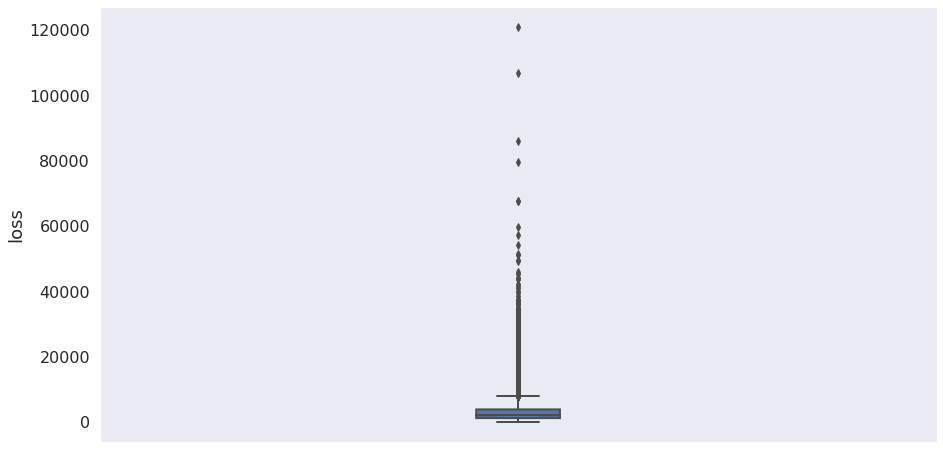

In [150]:
sns.boxplot(y=data['loss'], 
            width=0.1,
            notch=True)

In [151]:
def calcule_outlier_by_column(df_in, col_name):
    """
    Calculate quantile Q1 and Q3
    Calculate fence low and high
    Count outliers
    Add new collumn in dataframe with row with cointains outliers
    """    
    quantile_1 = df_in[col_name].quantile(q=0.25, interpolation='linear')
    quantile_3 = df_in[col_name].quantile(q=0.75, interpolation='linear')
    iqr = quantile_3-quantile_1 #Interquartile range
    print('IQR = ', iqr)
    
    fence_low  = quantile_1-1.5*iqr
    fence_high = quantile_3+1.5*iqr
    
    size = df_in.shape
    print('size dataframe = ',size)
    
    outlier_less_q1 = df_in[(df_in[col_name] < fence_low)].count()
    outlier_more_q3 = df_in[(df_in[col_name] > fence_high)].count()
    
#     # Create new column
#     mask = (df_in[col_name] < (quantile_1 - 1.5 * iqr)) | \
#            (df_in[col_name] > (quantile_3 + 1.5 * iqr))
#     df_in['outlier'] = mask.values
    
#     # Convert bool values in integer
#     df_in['outlier'] = df_in['outlier'].astype('uint8')
    
    
    return print('\nOutlier < quantile_1:\n{}\n\nOutlier > quantile_3:\n{}' \
                 .format(outlier_less_q1, outlier_more_q3))

In [152]:
calcule_outlier_by_column(data, 'loss')

IQR =  2659.5850000000005
size dataframe =  (313864, 132)

Outlier < quantile_1:
cat1      0
cat10     0
cat100    0
cat101    0
cat102    0
cat103    0
cat104    0
cat105    0
cat106    0
cat107    0
cat108    0
cat109    0
cat11     0
cat110    0
cat111    0
cat112    0
cat113    0
cat114    0
cat115    0
cat116    0
cat12     0
cat13     0
cat14     0
cat15     0
cat16     0
cat17     0
cat18     0
cat19     0
cat2      0
cat20     0
cat21     0
cat22     0
cat23     0
cat24     0
cat25     0
cat26     0
cat27     0
cat28     0
cat29     0
cat3      0
cat30     0
cat31     0
cat32     0
cat33     0
cat34     0
cat35     0
cat36     0
cat37     0
cat38     0
cat39     0
cat4      0
cat40     0
cat41     0
cat42     0
cat43     0
cat44     0
cat45     0
cat46     0
cat47     0
cat48     0
cat49     0
cat5      0
cat50     0
cat51     0
cat52     0
cat53     0
cat54     0
cat55     0
cat56     0
cat57     0
cat58     0
cat59     0
cat6      0
cat60     0
cat61     0
cat62     0
cat63  

In [153]:
display(data.shape)

(313864, 132)

In [154]:
data.head(15)

cat1 cat10 cat100 cat101 cat102 cat103 cat104 cat105 cat106 cat107 cat108  \
0     A     A      B      G      A      A      I      E      G      J      G   
1     A     B      L      F      A      A      E      E      I      K      K   
2     A     B      L      O      A      B      E      F      H      F      A   
3     B     A      I      D      A      A      E      E      I      K      K   
4     A     B      F      J      A      A      D      E      K      G      B   
5     A     A      J      D      A      A      E      E      H      F      B   
6     A     A      J      A      A      C      E      E      H      F      B   
7     A     A      H      C      A      A      K      F      F      I      G   
8     A     B      C      Q      A      C      H      F      G      M      K   
9     A     A      F      D      A      F      K      H      G      J      G   
10    A     B      H      Q      A      A      F      G      G      F      D   
11    A     B      H      M      A      B      G      I      I      F      B   
12    B     A      F      A      A      B      E      E      I      K      K   
13    B     A      I      A      A      B      D      E      J      G      A   
14    A     A      F      A      A      B      P      F      E      H      G   

   cat109 cat11 cat110 cat111 cat112 cat113 cat114 cat115 cat116 cat12 cat13  \
0      BU     B     BC      C     AS      S      A      O     LB     A     A   
1      BI     A     CQ      A     AV     BM      A      O     DP     A     A   
2      AB     B     DK      A      C     AF      A      I     GK     B     B   
3      BI     A     CS      C      N     AE      A      O     DJ     A     A   
4       H     A      C      C      Y     BM      A      K     CK     B     A   
5      BI     A     CS      A     AS     AE      A      K     DJ     A     A   
6      BI     A     DK      A      J     AF      A      K     DJ     A     A   
7      BI     A     EB      G     AH      Y      A      P     LO     A     A   
8      BI     B     BC      C      K     AX      A      Q     IE     B     B   
9      BU     A     DW      A      U      S      J      O     LY     A     A   
10     BI     B     AM      A     AS      H      A      K     GS     B     B   
11     BI     A     AI      A      E     AX      A      K     HK     B     B   
12     BI     A     CS      A      E     AE      A      O     DJ     A     A   
13     AB     A     EG      A     AK      K      E      K     DC     A     A   
14     BI     A     EG      A     AH      L      A      P     MP     A     A   

   cat14 cat15 cat16 cat17 cat18 cat19 cat2 cat20 cat21 cat22 cat23 cat24  \
0      A     A     A     A     A     A    B     A     A     A     B     A   
1      A     A     A     A     A     A    B     A     A     A     A     A   
2      A     A     A     A     A     A    B     A     A     A     A     A   
3      A     A     A     A     A     A    B     A     A     A     B     A   
4      A     A     A     A     A     A    B     A     A     A     B     A   
5      A     A     A     A     A     A    B     A     A     A     A     A   
6      A     A     A     A     A     A    A     A     A     A     A     A   
7      A     A     A     A     A     A    B     A     A     A     B     A   
8      A     A     B     A     A     A    B     A     A     A     B     A   
9      A     A     A     A     A     A    B     A     A     A     A     A   
10     A     A     A     A     A     A    B     A     A     A     A     A   
11     A     A     A     A     A     A    B     A     A     A     A     A   
12     A     A     A     A     A     A    A     A     A     A     A     A   
13     A     A     A     A     A     A    A     A     A     A     A     A   
14     A     A     A     A     A     A    A     A     A     A     A     A   

   cat25 cat26 cat27 cat28 cat29 cat3 cat30 cat31 cat32 cat33 cat34 cat35  \
0      A     A     A     A     A    A     A     A     A     A     A     A   
1      A     A     A     A     A    A     A     A     

Get 11554 outliers by column. 

In this context, outliers are important to analysis, so them ar not removed.

## Data Preprocessing
-  Log _loss_ transform
- Convert categorical string values to numeric values

### Log _loss_ transform
- Log transform help data to make gaussian distribuition

In [155]:
log_loss = np.log(data['loss'])

default_loss = data['loss']

### Convert categorical string values to numeric values

There are 116 categories with non alphanumeric values, most of the machine learning algorithms doesn't work with alpha numeric values. So, lets convert it into numeric values

In [156]:
# Separete datas in list with feature loss

continuous_types = []
categorical_types = []

for i in data.columns:
    
    if df_train[i].dtype == 'float':
        continuous_types.append(i)
    else:
        categorical_types.append(i)

categorical_types.remove('id')

display("Continuos Features: ", continuous_types)
print("Categorical Features: \n{}\n".format(categorical_types))

'Continuos Features: '

['cont1',
 'cont10',
 'cont11',
 'cont12',
 'cont13',
 'cont14',
 'cont2',
 'cont3',
 'cont4',
 'cont5',
 'cont6',
 'cont7',
 'cont8',
 'cont9',
 'loss']

Categorical Features: 
['cat1', 'cat10', 'cat100', 'cat101', 'cat102', 'cat103', 'cat104', 'cat105', 'cat106', 'cat107', 'cat108', 'cat109', 'cat11', 'cat110', 'cat111', 'cat112', 'cat113', 'cat114', 'cat115', 'cat116', 'cat12', 'cat13', 'cat14', 'cat15', 'cat16', 'cat17', 'cat18', 'cat19', 'cat2', 'cat20', 'cat21', 'cat22', 'cat23', 'cat24', 'cat25', 'cat26', 'cat27', 'cat28', 'cat29', 'cat3', 'cat30', 'cat31', 'cat32', 'cat33', 'cat34', 'cat35', 'cat36', 'cat37', 'cat38', 'cat39', 'cat4', 'cat40', 'cat41', 'cat42', 'cat43', 'cat44', 'cat45', 'cat46', 'cat47', 'cat48', 'cat49', 'cat5', 'cat50', 'cat51', 'cat52', 'cat53', 'cat54', 'cat55', 'cat56', 'cat57', 'cat58', 'cat59', 'cat6', 'cat60', 'cat61', 'cat62', 'cat63', 'cat64', 'cat65', 'cat66', 'cat67', 'cat68', 'cat69', 'cat7', 'cat70', 'cat71', 'cat72', 'cat73', 'cat74', 'cat75', 'cat76', 'cat77', 'cat78', 'cat79', 'cat8', 'cat80', 'cat81', 'cat82', 'cat83', 'cat84', 'cat85', 'cat86', 'cat87', 'cat88', 'cat89', 'cat9', 'cat90', 'cat9

In [157]:
# data df
# convert the categorical variables into numbers

data_copy = data.copy().loc[:, categorical_types]

for cat_feat in data_copy.columns:
    data_copy[cat_feat] = pd.factorize(data_copy[cat_feat], sort=True)[0]

In [158]:
data_copy.head()

cat1  cat10  cat100  cat101  cat102  cat103  cat104  cat105  cat106  \
0     0      0       1       6       0       0       8       4       6   
1     0      1      11       5       0       0       4       4       8   
2     0      1      11      14       0       1       4       5       7   
3     1      0       8       3       0       0       4       4       8   
4     0      1       5       9       0       0       3       4      10   

   cat107  cat108  cat109  cat11  cat110  cat111  cat112  cat113  cat114  \
0       9       6      46      1      28       2      19      57       0   
1      10      10      34      0      67       0      22      39       0   
2       5       0       2      1      87       0      28       6       0   
3      10      10      34      0      69       2      39       5       0   
4       6       1      67      0      51       2      50      39       0   

   cat115  cat116  cat12  cat13  cat14  cat15  cat16  cat17  cat18  cat19  \
0      14     288      0      0      0      0      0      0      0      0   
1      14      94      0      0      0      0      0      0      0      0   
2       8     167      1      1      0      0      0      0      0      0   
3      14      88      0      0      0      0      0      0      0      0   
4      10      63      1      0      0      0      0      0      0      0   

   cat2  cat20  cat21  cat22  cat23  cat24  cat25  cat26  cat27  cat28  cat29  \
0     1      0      0      0      1      0      0      0      0      0      0   
1     1      0      0      0      0      0      0      0      0      0      0   
2     1      0      0      0      0      0      0      0      0      0      0   
3     1      0      0      0      1      0      0      0      0      0      0   
4     1      0      0      0      1      0      0      0      0      0      0   

   cat3  cat30  cat31  cat32  cat33  cat34  cat35  cat36  cat37  cat38  cat39  \
0     0      0      0      0      0      0      0      0      0      0      0   
1     0      0      0      0      0      0      0      0      0      0      0   
2     0      0      0      0      0      0      0      1      0      0      0   
3     0      0      0      0      0      0      0      0      0      0      0   
4     0      0      0      0      0      0      0      0      0      0      0   

   cat4  cat40  cat41  cat42  cat43  cat44  cat45  cat46  cat47  cat48  cat49  \
0     1      0      0      0      0      0      0      0      0      0      0   
1     0      0      0      0      0      0      0      0      0      0      0   
2     0      0      0      0      0      0      0      0      0      0      0   
3     1      0      0      0      0      0      0      0      0      0      0   
4     1      0      0      0      0      0      0      0      0      0      0   

   cat5  cat50  cat51  cat52  cat53  cat54  cat55  cat56  cat57  cat58  cat59  \
0     0      0      0      0      0      0      0      0      0      0      0   
1     0      0      0      0      0      0      0      0      0      0      0   
2     1      0      0      0      0      0      0      0      0      0      0   
3     0      0      0      0      0      0      0      0      0      0      0   
4     0      0      0      0      0      0      0      0      0      0      0   

   cat6  cat60  cat61  cat62  cat63  cat64  cat65  cat66  cat67  cat68  cat69  \
0     0      0      0      0      0      0      0      0      0      0      0   
1     0      0      0      0      0      0      0      0      0      0      0   
2     0      0      0      0      0      0      0      0      0      0      0   
3     0      0      0      0      0      0      0      0      0      0      0   
4     0      0      0      0      0      0      0      0      0      0      0   

   cat7  cat70  cat71  cat72  cat73  cat74  cat75  cat76  cat77  cat78  cat79  \
0     0      0      0      0      0      0      1      0      3      1      1   
1     0      0      0      0      0      

## Data Visualization

- Loss Variable
- Continuous feature
 - Visualize data continuos
 - Correlation data continuos
 - Matrix correlation: continuous features
- Categorical feature
 - Transform categorical feature
 - Visualize data categorical
 - Matrix correlation: categorical features

### _Loss_ target

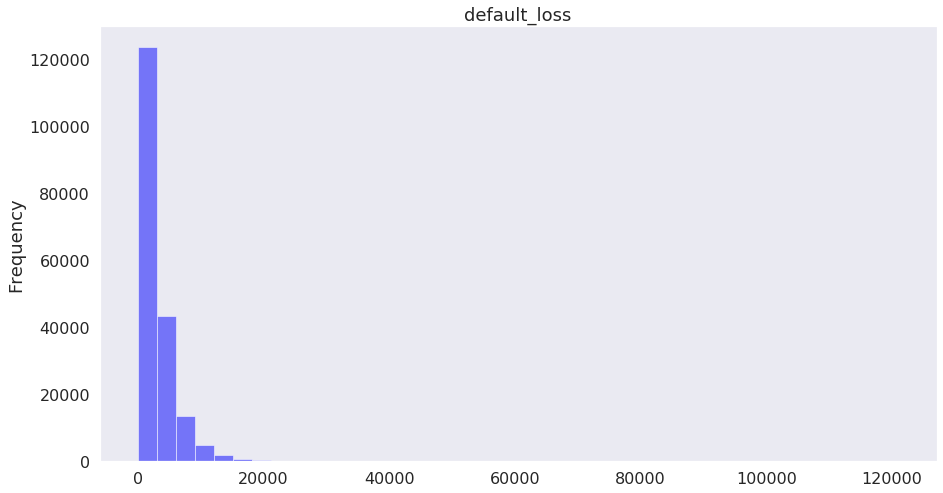

In [159]:
# Plot showing loss distribution
plt.figure()
default_loss_img = default_loss.plot.hist(alpha=0.5, color = 'blue', bins = 40)
plt.title("default_loss")
plt.show()

In [160]:
# savefig()

def save_image(img: 'matplotlib',
               name: str,
               path: str = 'reports/images/'):
    fig = img.get_figure()
    fig.savefig(f"reports/images/{name}.png")
    
    return f"Image {name} saved."

In [161]:
save_image(img=default_loss_img, name='default_loss')

'Image default_loss saved.'

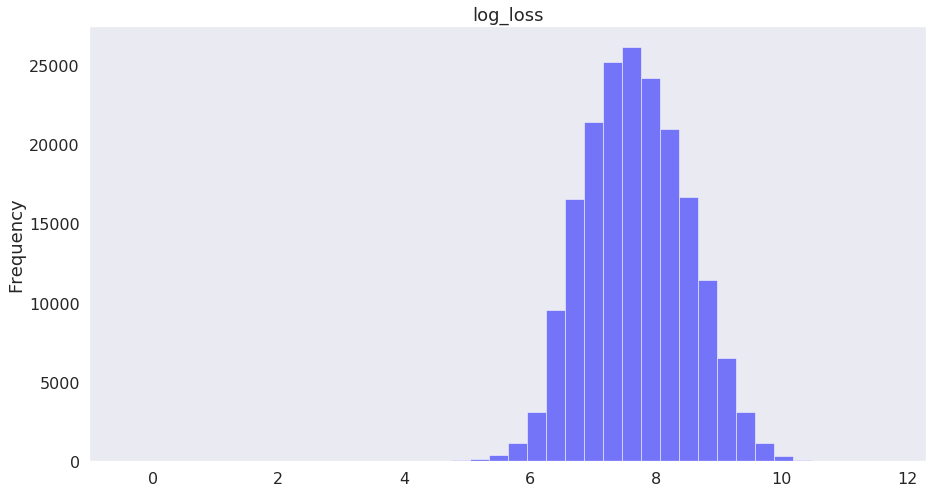

In [162]:
# Plot showing loss distribution
plt.figure()
log_loss_img = log_loss.plot.hist(alpha=0.5,
                                  color = 'blue',
                                  bins = 40)
plt.title("log_loss")
plt.show()

In [163]:
save_image(img=log_loss_img, name='log_loss')

'Image log_loss saved.'

It`s possible see that it is skewed to the left.

#### PCA (Kernel Density Estimate)

In [164]:
### Preparing data to KDE

lable = df_train['loss'].values
dataset_visual = df_train.drop(['loss'], axis = 1)
dataset_visual = df_train[continuous_types].values
dataset_visual = StandardScaler().fit_transform(dataset_visual)

# import some data to play
X = dataset_visual
y = data['loss']

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

pca = PCA(n_components=3)
principalComponents  = pca.fit_transform(X)

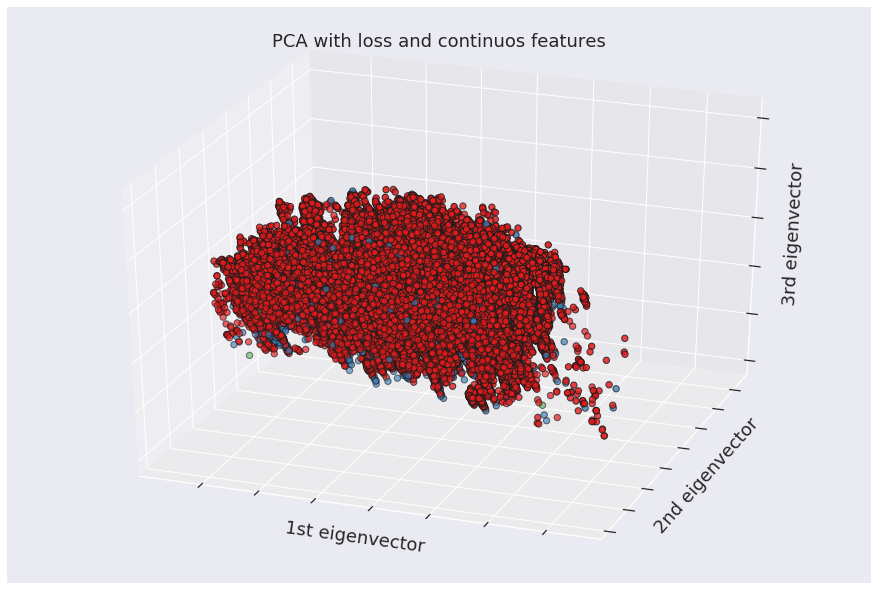

In [165]:
# Plotting a Kernel Density Estimate (KDE) with three PCA dimensions
fig3 = plt.figure(2, figsize=(12, 8))
ax2 = Axes3D(fig3, elev=-150, azim=70)
pca_img = ax2.scatter(principalComponents[:, 0],
                      principalComponents[:, 1], 
                      principalComponents[:, 2],
                      c=lable, 
                      cmap=plt.cm.Set1,
                      edgecolor='k', s=40)

ax2.set_title("PCA with loss and continuos features")
ax2.set_xlabel("1st eigenvector")
ax2.w_xaxis.set_ticklabels([])
ax2.set_ylabel("2nd eigenvector")
ax2.w_yaxis.set_ticklabels([])
ax2.set_zlabel("3rd eigenvector")
ax2.w_zaxis.set_ticklabels([])

plt.show()

In [166]:
# PCA data variance
print(pca.explained_variance_ratio_)

[0.41029323 0.13688825 0.10094782]


It is seen that the data are well grouped and presented in a PCA of 3 dimensions for each one of its components the variance of 5.97%, 4.73% and 4.29%, being a total of 14.99%.

In [167]:
save_image(img=pca_img, name='PCA')

'Image PCA saved.'

#### Data  Continuos Distribuition

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe446ed9908>,
      dtype=object)

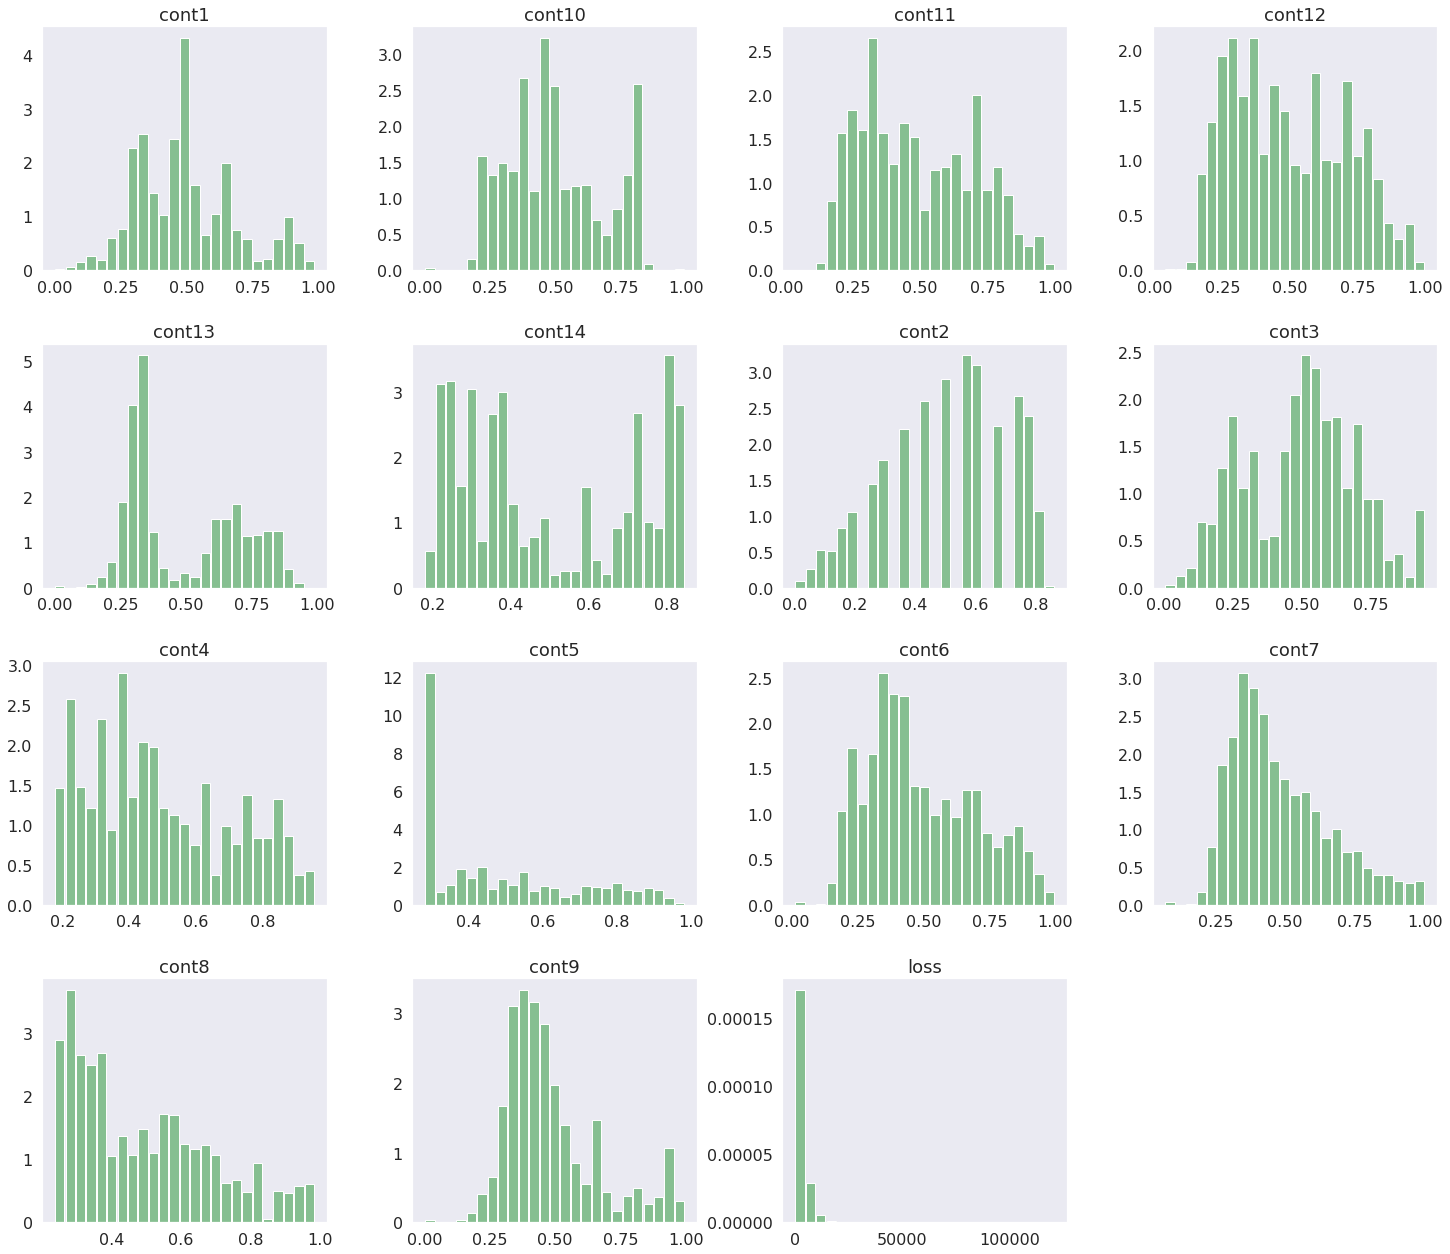

In [168]:
# the histogram of the data
data[continuous_types].hist(figsize=[25,22], 
                            density=True, 
                            bins=25, 
                            grid=False, 
                            color='#86bf91', 
                            zorder=2, 
                            rwidth=0.9)

#### Correlations

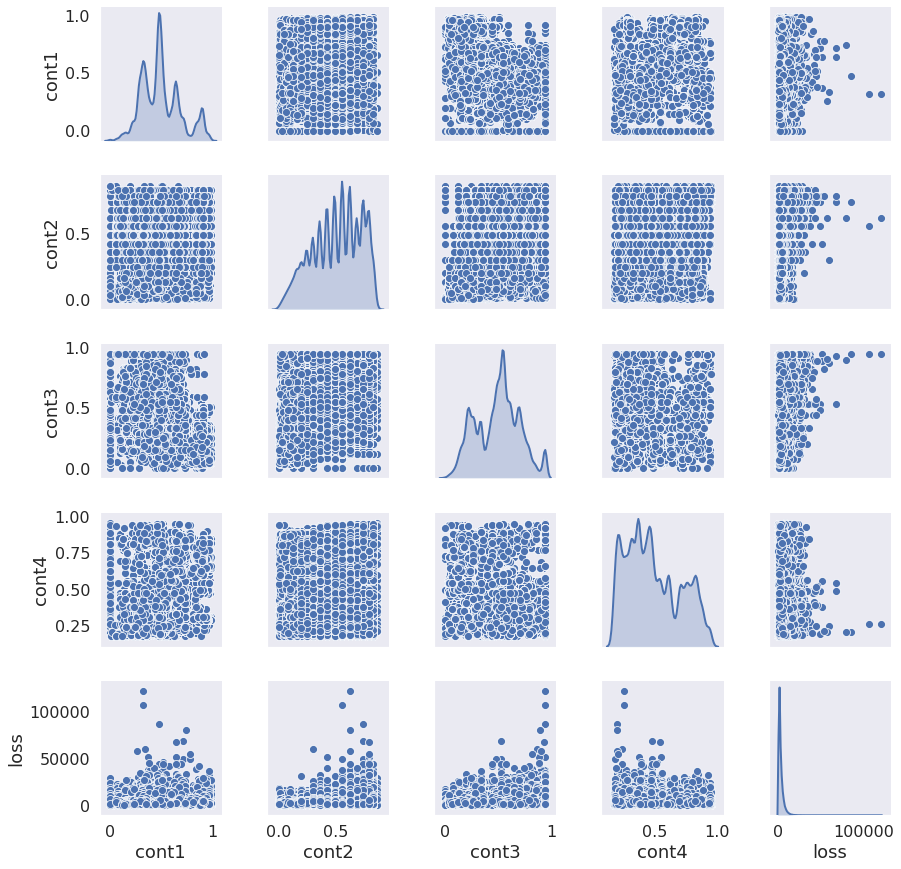

In [169]:
corr_cont_types_1_ate_4 = sns.pairplot(df_train[continuous_types],
                                       vars=['cont1',
                                             'cont2',
                                             'cont3',
                                             'cont4',
                                             'loss'],
                                       kind = 'scatter',
                                       diag_kind='kde')
print(corr_cont_types_1_ate_4)

In [170]:
# save image
fig = corr_cont_types_1_ate_4.fig.savefig("reports/images/corr_cont_types_1_ate_4.png")
print(f"Output (corr_cont_types_1_ate_4) saved.")

Output (corr_cont_types_1_ate_4) saved.


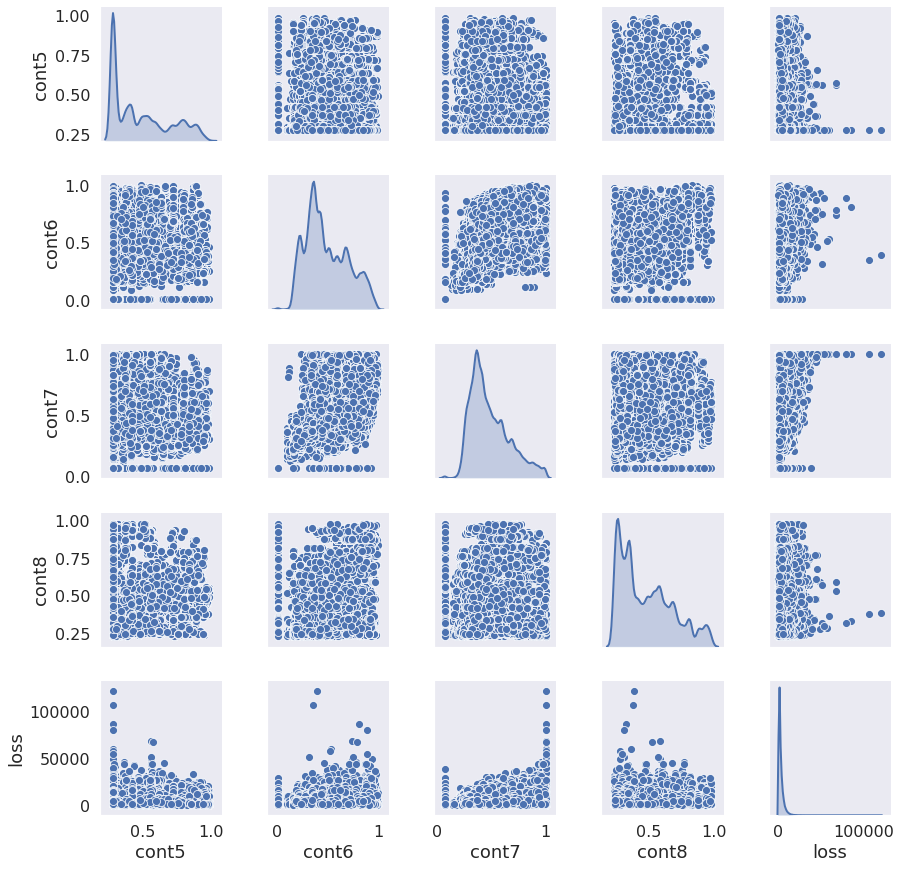

In [171]:
corr_cont_types_5_ate_8 = sns.pairplot(df_train[continuous_types],
                                       vars=['cont5',
                                             'cont6',
                                             'cont7',
                                             'cont8',
                                             'loss'],
                                       kind = 'scatter',
                                       diag_kind='kde')
print(corr_cont_types_5_ate_8)

In [172]:
# save image
fig = corr_cont_types_5_ate_8.savefig("reports/images/corr_cont_types_5_ate_8.png")
print(f"Output (corr_cont_types_5_ate_8) saved.")

Output (corr_cont_types_5_ate_8) saved.


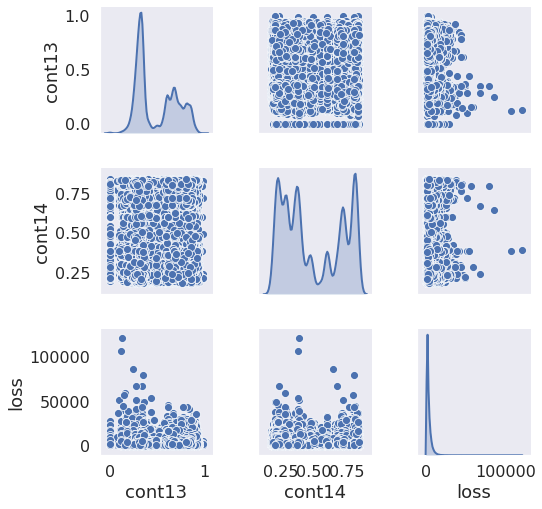

In [173]:
corr_cont_types_13_ate_14 = sns.pairplot(df_train[continuous_types],
                                        vars=['cont13',
                                              'cont14',
                                              'loss'],
                                        kind = 'scatter',
                                        diag_kind='kde')
print(corr_cont_types_13_ate_14)



In [174]:
# save image
fig = corr_cont_types_13_ate_14.savefig("reports/images/corr_cont_types_13_ate_14.png")
print(f"Output (corr_cont_types_13_ate_14) saved.")

Output (corr_cont_types_13_ate_14) saved.


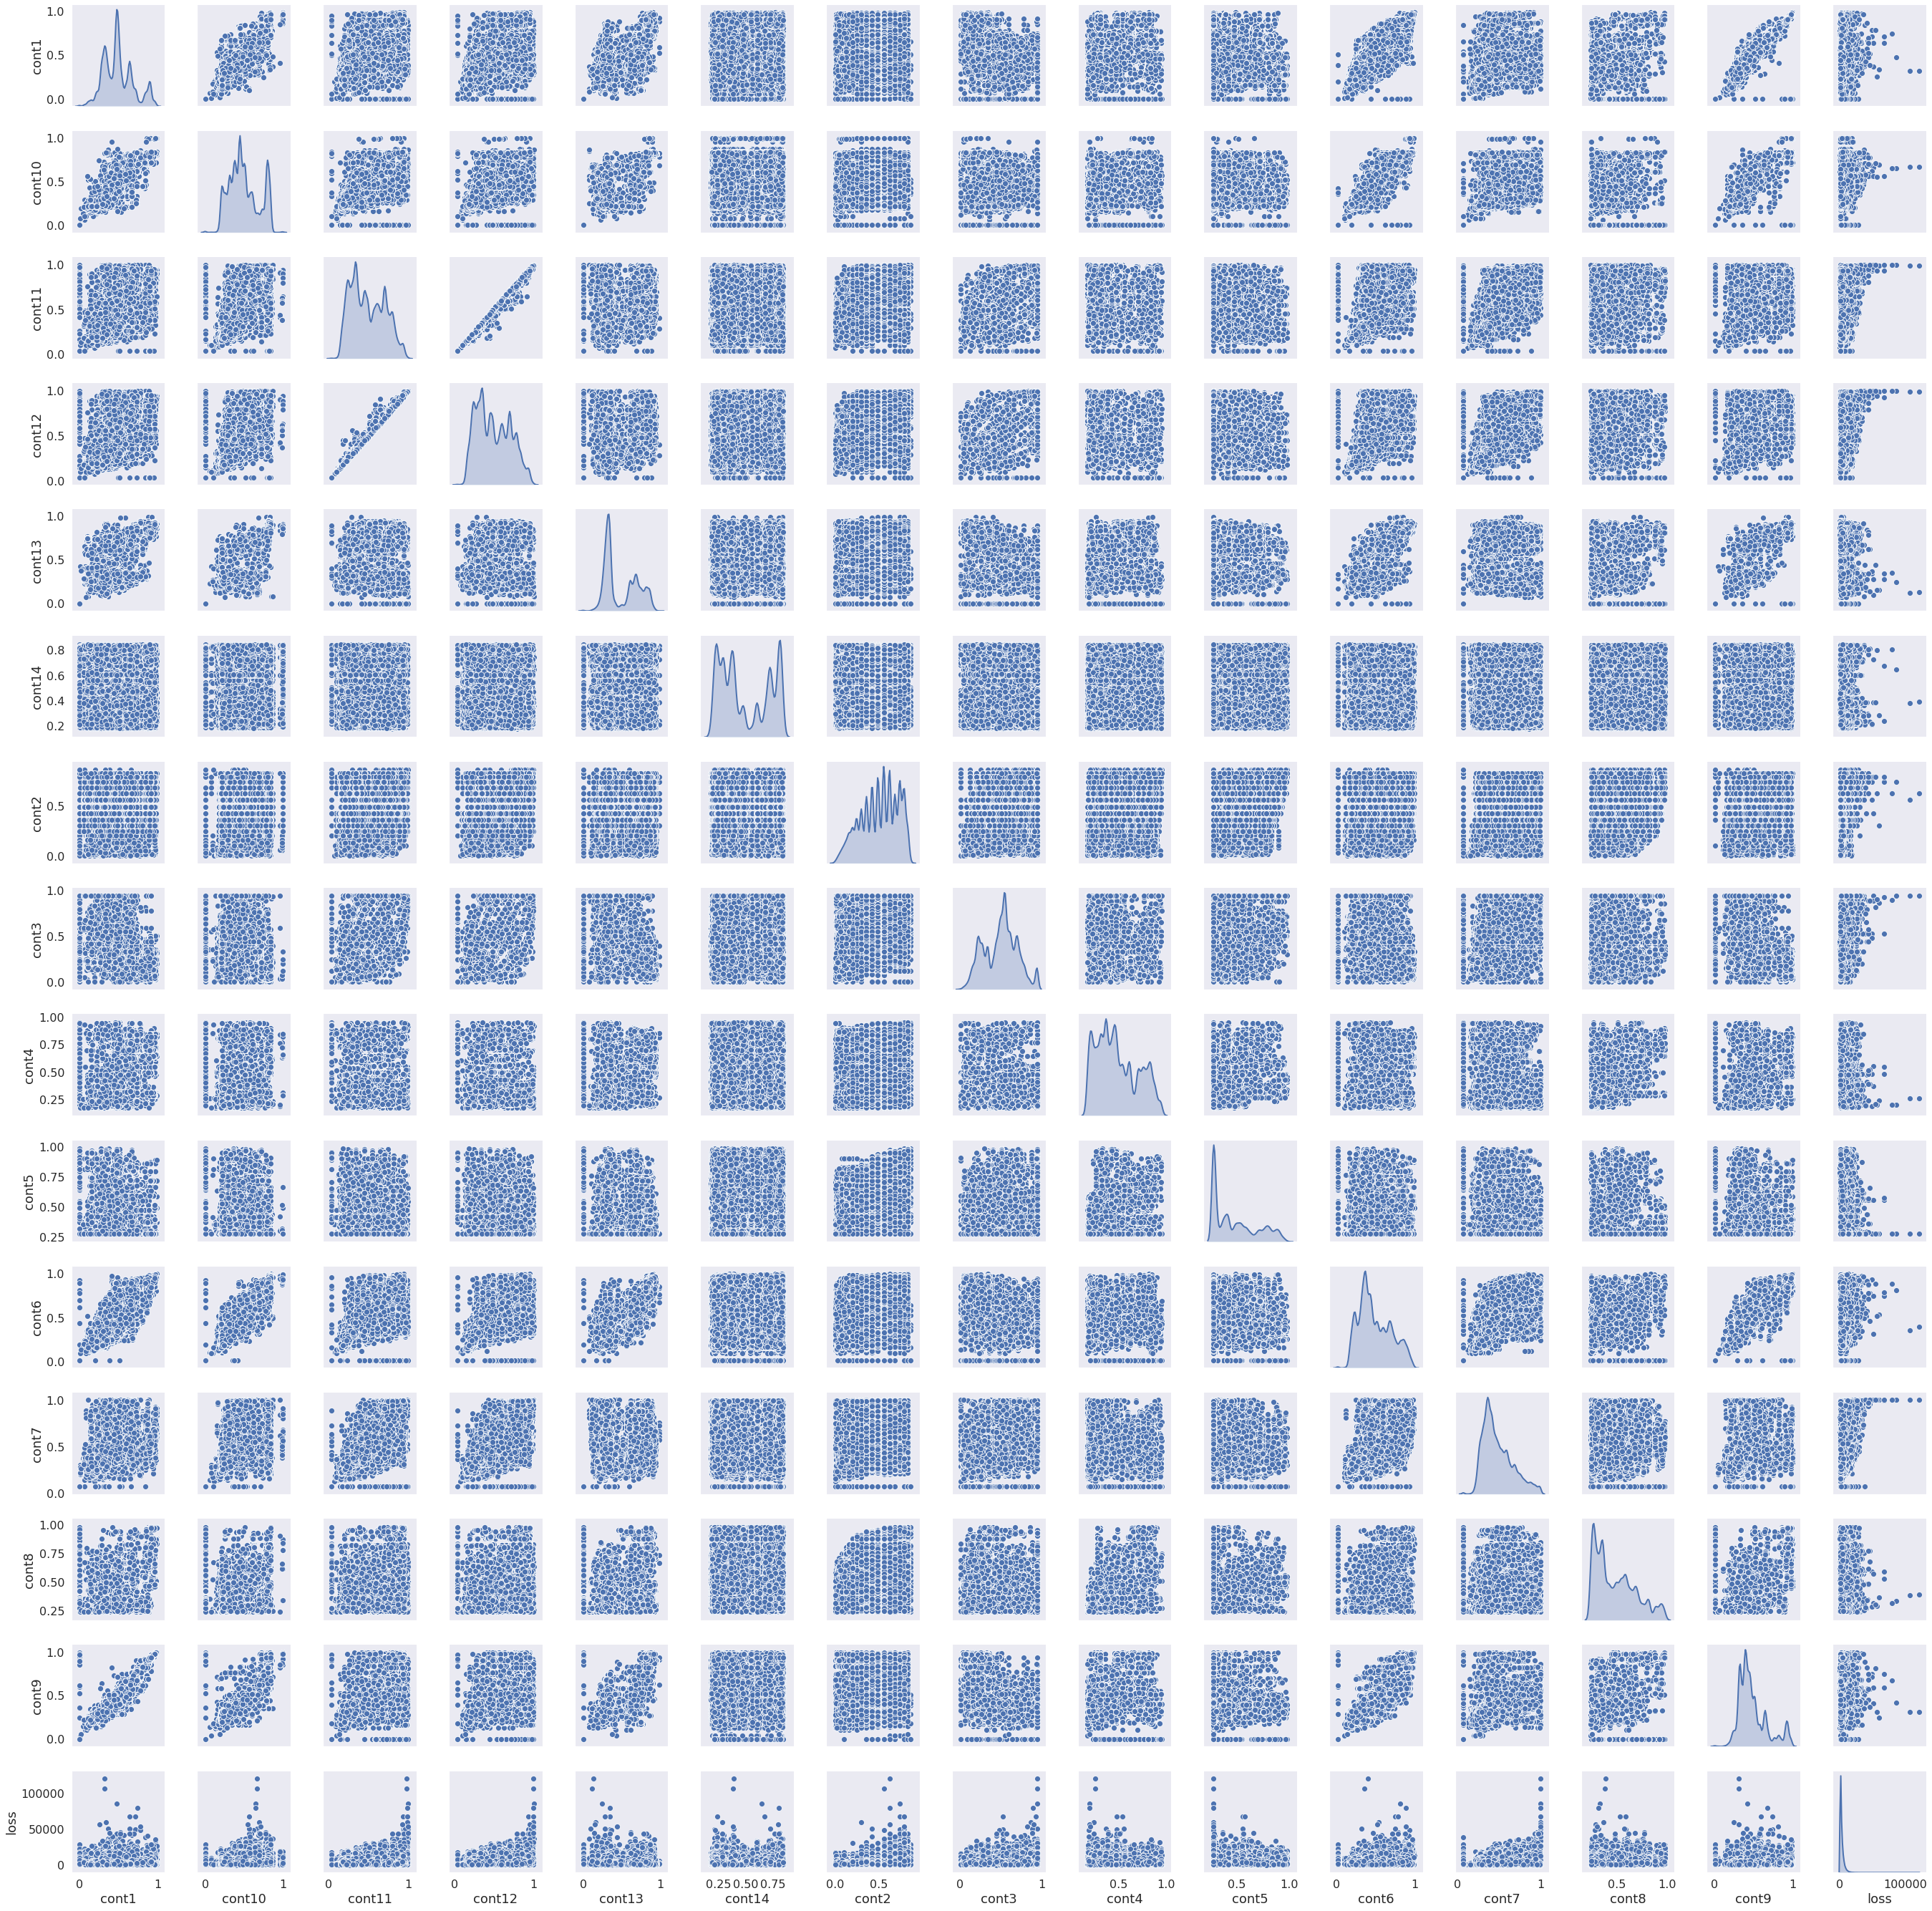

In [175]:
corr_cont_types_all = sns.pairplot(
    df_train[continuous_types],
    kind = 'scatter',
    diag_kind='kde')

In [176]:
# save image
fig = corr_cont_types_all.savefig("reports/images/corr_cont_types_all.png")
print(f"Output (corr_cont_types_all) saved.")

Output (corr_cont_types_all) saved.


### Matrix correlation: continuous features

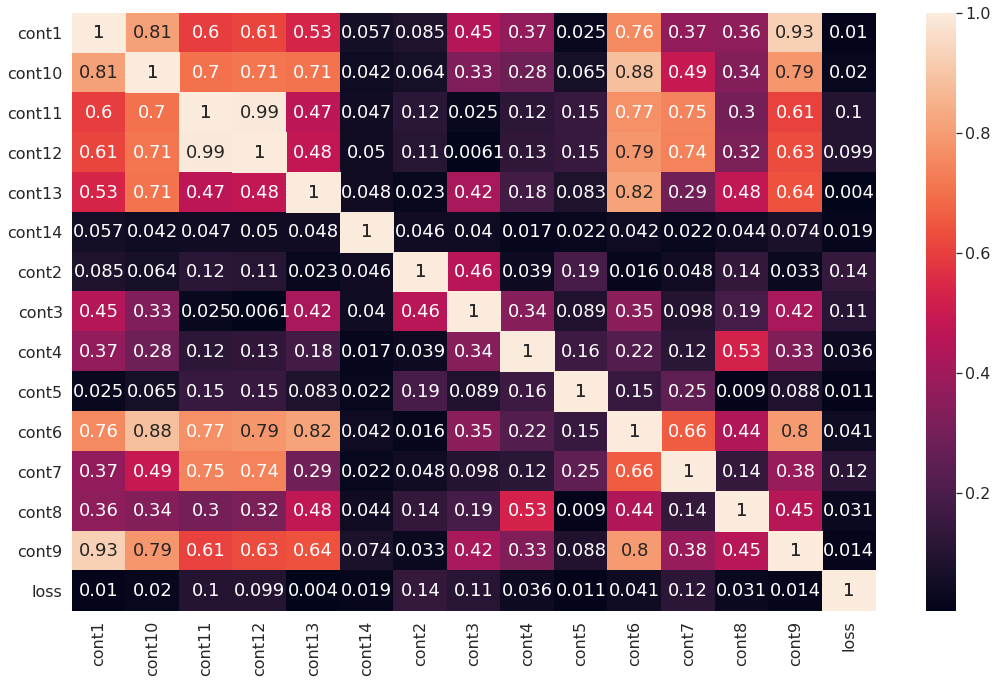

In [177]:
correlationMatrix = df_train[continuous_types].corr().abs()

plt.subplots(figsize=(18, 11))
sns.heatmap(correlationMatrix,annot=True)

# Mask unimportant features
corr_matrix_cont = sns.heatmap(correlationMatrix,
            mask=correlationMatrix < 1,
            cbar=False,
            linecolor='white',
            annot = True)
plt.show()

In [178]:
# save image
corr_matrix_cont.figure.savefig("reports/images/corr_matrix_cont.png")
print(f"Output (corr_matrix_cont) saved.")

Output (corr_matrix_cont) saved.


It`s possible see correlations exists between some of the continuous variables.
In this case, the correlations score between cont10 and cont11 is 0.7. 

### Categorical features

#### Best correlation in categorical feature

In [179]:
corrCatMatrix = data_copy[categorical_types].corr().abs()

s = corrCatMatrix.unstack()
sortedSeries = s.sort_values(kind="quicksort",ascending=False)
best_correlation_categorical = sortedSeries[sortedSeries != 1.0][0:10]

print("Top correlated categorical feature pairs: \n")
print(best_correlation_categorical)

Top correlated categorical feature pairs: 

cat90   cat3     0.96
cat3    cat90    0.96
cat89   cat7     0.95
cat7    cat89    0.95
cat9    cat2     0.93
cat2    cat9     0.93
cat6    cat50    0.93
cat50   cat6     0.93
cat116  cat104   0.92
cat104  cat116   0.92
dtype: float64


## Prepare Submission File
Use function to submission. In this way it is guaranteed a default.

In [180]:
# First, check how is file sample
sample = pd.read_csv('data/raw/sample_submission.csv')
sample.head()

id  loss
0   4     0
1   6     0
2   9     0
3  12     0
4  15     0

In [181]:
test_ids = df_test['id']

submissions_folder = 'data/submissions-kaggle/'

In [182]:
def save_predictions(ids = None, predictions = None, file = None):
    
    # prepare file
    submission = pd.DataFrame({'id': ids, 'loss': predictions})
    
    # CSV
    submission.to_csv(path_or_buf = file, index = False, encoding='utf8')
    print("Data storage!")

---

## Split train and test
- The variable Shift is applied to the log transformation.

In [183]:
# split into training and test sets
shift = 200

# create target label
X_train = df_train[continuous_types]
y_train = np.log(df_train['loss'] + shift)

X_test = df_test[continuous_types]

KeyError: "['loss'] not in index"

In [ ]:
X_train.head()

In [ ]:
X_test.head()

In [ ]:
y_train.head()

In [ ]:
# check distribuition
print ("Xtrain shape:", X_train.shape[0])
print ("ytrain shape:", X_train.shape[1])
print ("Xtest shape:", X_test.shape[0])
print ("ytest shape:", X_test.shape[1])

## Mean absolute error (MAE) 
- The models in this project use the mean absolute error (MAE) between the predicted loss and the actual loss for each claim in the test set.
- The goal was to minimize the MAE in our model’s predictions. 

In [ ]:
# Custom eval metric
def eval_error(preds, dtrain):
    """evaluation"""
    labels = dtrain.get_label()
    return 'mae', mean_absolute_error(np.exp(preds), np.exp(labels))

## K-Folds Cross Validation
KFold divides all the samples in  groups of samples, called folds, of equal sizes (if possible). The prediction function is learned using  folds, and the fold left out is used for test.

In [ ]:
# replicate the results
random_state = 16

# folds
k = 5

## Function tranning
- The traning and test it`s in function because garanted reuse.
- The predictions running in validation set in each fold.
- Garanted with array is the inverse of the log transformation about column loss.
- Calculate time
- Calculate MAE

In [ ]:
def train_model(model, num_folds):
    """Function by Train model"""
        
    print("Begin training")
    start = time.time()
    
    # declare a KFold instance
    kfold = KFold(n_splits = num_folds, random_state = 10)
    
    # number of models
    num_models = 1
    
    # array to store results after each fold
    results = np.zeros((X_test.shape[0], k))
        
    # train K-1 Random Forests
    for i, (train, val) in enumerate(kfold.split(X_train)):
        # get smaller training set and create validation set
        X_train_mini, X_val = X_train.iloc[train], X_train.iloc[val]
        y_train_mini, y_val = y_train[train], y_train[val]

        # train model
        model.fit(X_train_mini, y_train_mini)

        # make predictions 
        preds = model.predict(X_val)
        
        # absolute error
        error = mean_absolute_error(np.exp(y_val) - shift, np.exp(preds) - shift)
        print("MAE on fold {} is {}".format(i, error))

        
        # Predict on test set
        test_predictions = np.exp(model.predict(X_test)) - shift
        
        # Sum predictions
        results[:,i] = test_predictions
        

    end = time.time()
    print("\nTraining done! Time Elapsed:", end - start, " seconds.")

    # Error over k folds
    avg_error = np.mean(results)

    return test_predictions

## Benchmarks

We will test and execute the models:
- Linear Regression
- Random Forest (Bagging)
- XGBoost

## Linear Regression

In [ ]:
# Visualize params
LinearRegression()

In [ ]:
# Linear Regression
model_lr = LinearRegression(n_jobs=-1, normalize=False)

# training
result_lr = train_model(model = model_lr, num_folds = 5)

In [ ]:
# Linear Regression normalized
model_lr_normalized = LinearRegression(n_jobs=-1, normalize=True)

# training
result_lr_normalized = train_model(model = model_lr_normalized, num_folds = 5)

#### Analysis of Results
- Without difference data normalized and not normalized
- The best result MAE on fold 4 is 1791.1369743102152

#### Submission

In [ ]:
save_predictions(ids = test_ids, 
                 predictions = result_lr_normalized, 
                 file = submissions_folder + 'lin_regression_submission.csv')

#### View file

In [ ]:
sub = pd.read_csv(submissions_folder + 'lin_regression_submission.csv')
sub.head()

## Random Forest

#### Process trainning
- The number of estimators go is tested.
- Update the number of estimators to 20, 50 and 100 to see how the model performs. 

In [ ]:
# Visualize params
RandomForestRegressor()

In [ ]:
# 1st model Random Forest
rf_regressor_one = RandomForestRegressor(n_estimators = 20, 
                                         n_jobs = -1,
                                         verbose = 1, 
                                         max_depth = 30)

# training
result_rf_1 = train_model(model = rf_regressor_one, num_folds = 5)

In [ ]:
# 2st model Random Forest
rf_regressor_two = RandomForestRegressor(n_estimators = 50, 
                                         n_jobs = -1,
                                         verbose = 1, 
                                         max_depth = 30)

# training
result_rf_2 = train_model(model = rf_regressor_two, num_folds = 5)

In [ ]:
# 3st model Random Forest
rf_regressor_three = RandomForestRegressor(n_estimators = 100, 
                                          n_jobs = -1,
                                          verbose = 1, 
                                          max_depth = 30)

# training
result_rf_3 = train_model(model = rf_regressor_three, num_folds = 5)

#### Analysis of Results
- The increasing the number of estimators improved score.
- The best results produced with n_estimators = 100 on fold 1.
- The best result MAE on fold 1 is 1854.7308563695506
- The problem is time process which grows in the same proportion. 
- The model random forest were worse than linear regression

#### Submission

In [ ]:
save_predictions(ids = test_ids, 
                 predictions = result_rf_1, 
                 file = submissions_folder + 'random_forest_submission.csv')

#### View submission

In [ ]:
sub = pd.read_csv(submissions_folder + 'random_forest_submission.csv')
sub.head()

## XGBoost
- Model very robust
- descentent gradient 
- regularization parameter: help avoid overfitting
- parallelizable

The model XGBRegressor will be trained with threee model using difference parameters.

#### Otimize XGBoost

DMatrix is a internal data structure that used by XGBoost which is optimized for both memory efficiency and training speed.

In [ ]:
# Data Matrix used in XGBoost.
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)

#### Function  train_test_xgboost
- The function process data to:
 - calculate time process
 - shuffle the data during each fold
 - run predictions
 - store these predictions in a numpy array
 - average the predictions over k number of folds.

In [ ]:
def train_test_xgboost(model, early_stopping_rounds):
    kf = KFold(n_splits = k, shuffle = True, random_state = random_state)
    results = np.zeros((X_test.shape[0], k))
    
    print("Begin training")
    start = time.time()
    
    for i, (train_index, val_index) in enumerate(kf.split(X_train)):
        print("Begin training and testing base model on fold {}".format(i))
        start = time.time()
        
        X_train_mini, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_mini, y_val = y_train[train_index], y_train[val_index]

        # train model
        model.fit(X_train_mini, 
                   y_train_mini, 
                   eval_metric = eval_error, 
                   eval_set = [(X_train_mini, y_train_mini), (X_val, y_val)], 
                   early_stopping_rounds = early_stopping_rounds,
                   verbose = False)

        end = time.time()
        print("Training time elapsed on fold {} is {}".format(i, end - start))
        
        # Predict on validation set 
        val_predictions = model.predict(X_val, ntree_limit = model.best_ntree_limit)
        error = mean_absolute_error(np.exp(y_val) - shift, np.exp(val_predictions) - shift)
        print("Error on fold {} is {} \n".format(i, error))
                
        # Predict on test set
        test_predictions = np.exp(model.predict(X_test, ntree_limit = model.best_ntree_limit)) - shift
        # Sum predictions
        results[:,i] = test_predictions
        
        end = time.time()
        print("\nTraining done! Time Elapsed:", end - start, " seconds.")

    # Average predictions
    mean_results = results.mean(axis = 1)
    return mean_results

In [ ]:
# Visualize params
XGBRegressor()

#### Chooce parameters
It´s possible reduce error and overfitting with analysis of parameters. Here is a list of the key parameters below:

- max_depth - Max tree depth for boosted trees
- gamma - Minimum loss reduction required to make a further partition on a leaf node of the tree.
- min_child_weight - Minimum sum of instance weight(hessian) needed in a child.

**NOTE**: keep someone parameters default, how by example, learning_rate=0.1.<br/>
**NOTE about n_estimators**: when tested there aren´t effect

In [ ]:
# Model 1 XGB_regressor
xgb_one = XGBRegressor(learning_rate=0.1,
                       n_estimators = 1000,
                       max_depth = 7,
                       min_child_weight = 5.0,
                       gamma = 0.0,
                       subsample = 1.0,
                       colsample_bytree = 1.0,
                       reg_alpha = 1.0,
                       silent = True, 
                       seed = random_state, 
                       nthread = -1)

# training
results_xgb_1 = train_test_xgboost(model = xgb_one,
                                   early_stopping_rounds = 50)

In [ ]:
# Model 2 XGB_regressor
xgb_two = XGBRegressor(learning_rate=0.1,
                       n_estimators = 1000,
                       max_depth = 5,
                       min_child_weight = 6.0,
                       gamma = 1,
                       subsample = 1.0,
                       colsample_bytree = 1.0,
                       reg_alpha = 1.0,
                       silent = True, 
                       seed = random_state, 
                       nthread = -1)
# training
results_xgb_2 = train_test_xgboost(model = xgb_two,
                                   early_stopping_rounds = 50)

In [ ]:
# Model 3 XGB_regressor
xgb_three = XGBRegressor(learning_rate=0.1,
                        n_estimators = 1000,
                        max_depth = 9,
                        min_child_weight = 6,
                        gamma = 1,
                        subsample = 1.0,
                        colsample_bytree = 0.5,
                        reg_alpha = 1.0,
                        silent = True, 
                        seed = random_state, 
                        nthread = -1)

# training
results_xgb_3 = train_test_xgboost(model = xgb_three,
                                   early_stopping_rounds = 50)

#### Submission

In [ ]:
save_predictions(ids = test_ids, 
                 predictions = results_xgb_1, 
                 file = submissions_folder + 'xgb_submission.csv')

#### View submission

In [ ]:
sub = pd.read_csv(submissions_folder + 'xgb_submission.csv')
sub.head()

#### Analysis of Results
- The XGBoost have better performace in comparain Random Forest and Linear Regression
- The best result MAE on fold 0 is 1753.6550894377651 in three model
- I tested parameters difference in each model XGBoost
- So, I chooce file xgb_submission to submission in competition.

---

#### Copyright
<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">
    <img alt="Creative Commons License" align="right" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" />
</a><br />This work by 
    <span xmlns:cc="http://creativecommons.org/ns#" property="cc:attributionName">Bruno A. R. M. Campos</span> is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.